# Offline Attention Extraction

This notebook loads a trained model and extracts attention weights from the Wayformer encoder
by running inference on scenarios from the dataset.

**Workflow:**
1. Load trained model checkpoint
2. Load scenarios from dataset
3. Run forward pass with `return_attention_weights=True`
4. Save/analyze the extracted attention weights

Setup

In [1]:
import os
import sys
import pickle
import glob
import yaml
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial

Add project root to path

In [2]:
from waymax import dynamics
from vmax.simulator import make_env_for_evaluation, datasets, make_data_generator
from vmax.agents.learning.reinforcement.ppo import ppo_factory
from vmax.scripts.evaluate.utils import load_params, load_yaml_config

2026-01-22 16:14:48.978110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769098488.991730  245654 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769098488.996024  245654 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/djalal/conda-envs/vmax/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Configuration

In [4]:
RUN_DIR = "../../runs/PPO_VEC_WAYFORMER/"  # Path to training run
DATASET_PATH = "../../training.tfrecord"  # Dataset name or path
NUM_SCENARIOS = 10  # Number of scenarios to process
OUTPUT_DIR = "attention_extractions/"  # Where to save results

Derived paths

In [5]:
MODEL_DIR = os.path.join(RUN_DIR, "model")
CONFIG_PATH = os.path.join(RUN_DIR, ".hydra/config.yaml")

In [6]:
print(f"Run directory: {RUN_DIR}")
print(f"Config path: {CONFIG_PATH}")

Run directory: ../../runs/PPO_VEC_WAYFORMER/
Config path: ../../runs/PPO_VEC_WAYFORMER/.hydra/config.yaml


### 2. ENCODER (Wayformer) LOCALLY
TO ENSURE SUPPORT FOR ATTENTION EXTRACTION

In [7]:
# --- REDEFINE ALL ATTENTION COMPONENTS LOCALLY ---
import einops
import jax.nn.initializers as init
from flax import linen as nn
from vmax.agents.networks import encoders
from functools import partial
import jax
import jax.numpy as jnp
from vmax.agents import datatypes

def default(val, d):
    """Return val if val is not None, else d."""
    return val if val is not None else d

class LocalAttentionLayer(nn.Module):
    """Local version of AttentionLayer with return_attention_weights support."""
    heads: int = 8
    head_features: int = 64
    dropout: float = 0.0
    return_attention_weights: bool = False

    @nn.compact
    def __call__(self, x: jax.Array, context=None, mask_k=None, mask_q=None, deterministic: bool = False):
        h = self.heads
        dim = self.head_features * h

        q = nn.Dense(dim, use_bias=False)(x)
        k = nn.Dense(dim, use_bias=False)(default(context, x))
        v = nn.Dense(dim, use_bias=False)(default(context, x))

        q, k, v = map(lambda arr: einops.rearrange(arr, "b n (h d) -> b n h d", h=h), (q, k, v))
        sim = jnp.einsum("b i h d, b j h d -> b i j h", q, k) * self.head_features**-0.5

        if mask_k is not None:
            big_neg = jnp.finfo(jnp.float32).min
            sim = jnp.where(mask_k[:, None, :, None], sim, big_neg)
        if mask_q is not None:
            big_neg = jnp.finfo(jnp.float32).min
            sim = jnp.where(mask_q[:, :, None, None], sim, big_neg)

        attn = nn.softmax(sim, axis=-2)
        attn_weights_for_analysis = attn if self.return_attention_weights else None
        
        out = jnp.einsum("b i j h, b j h d -> b i h d", attn, v)
        out = einops.rearrange(out, "b n h d -> b n (h d)", h=h)

        out = nn.Dense(x.shape[-1])(out)
        out = nn.Dropout(self.dropout)(out, deterministic=deterministic)

        if self.return_attention_weights:
            return out, attn_weights_for_analysis
        return out

class LocalWayformerAttention(nn.Module):
    depth: int = 2
    num_latents: int = 32
    num_heads: int = 2
    head_features: int = 16
    ff_mult: int = 1
    attn_dropout: float = 0.0
    ff_dropout: float = 0.0
    return_attention_weights: bool = False

    @nn.compact
    def __call__(self, x, mask=None):
        bs, dim = x.shape[0], x.shape[-1]
        latents = self.param("latents", init.normal(), (self.num_latents, dim * self.ff_mult))
        latent = einops.repeat(latents, "n d -> b n d", b=bs)
        x = einops.rearrange(x, "b n ... -> b n (...)")

        attention_weights = {} if self.return_attention_weights else None

        # Use LOCAL attention layer instead of encoders.AttentionLayer
        attn = partial(
            LocalAttentionLayer,
            heads=self.num_heads,
            head_features=self.head_features,
            dropout=self.attn_dropout,
            return_attention_weights=self.return_attention_weights
        )
        ff = partial(encoders.FeedForward, mult=self.ff_mult, dropout=self.ff_dropout)
        
        # Cross-attention (attn_0)
        rz = encoders.ReZero(name="rezero_0")
        if self.return_attention_weights:
            attn_out, attn_w = attn(name="attn_0")(latent, x, mask_k=mask)
            latent += rz(attn_out)
            attention_weights['cross_attn_0'] = attn_w
        else:
            latent += rz(attn(name="attn_0")(latent, x, mask_k=mask))
        latent += rz(ff(name="ff_0")(latent))

        # Self-attention layers
        for i in range(1, self.depth):
            rz = encoders.ReZero(name=f"rezero_{i}")
            if self.return_attention_weights:
                attn_out, attn_w = attn(name=f"attn_{i}")(latent)
                latent += rz(attn_out)
                attention_weights[f'self_attn_{i}'] = attn_w
            else:
                latent += rz(attn(name=f"attn_{i}")(latent))
            latent += rz(ff(name=f"ff_{i}")(latent))

        if self.return_attention_weights:
            return latent, attention_weights
        return latent

class LocalWayformerEncoder(nn.Module):
    unflatten_fn: callable = lambda x: x
    embedding_layer_sizes: tuple = (256, 256)
    embedding_activation: datatypes.ActivationFn = nn.relu
    attention_depth: int = 2
    dk: int = 64
    num_latents: int = 64
    latent_num_heads: int = 4
    latent_head_features: int = 64
    ff_mult: int = 2
    attn_dropout: float = 0.0
    ff_dropout: float = 0.0
    fusion_type: str = "late"
    return_attention_weights: bool = False

    @nn.compact
    def __call__(self, obs: jax.Array):
        # Add batch dimension if missing
        if obs.ndim == 1:
            obs = jnp.expand_dims(obs, axis=0)
        
        features, masks = self.unflatten_fn(obs)
        sdc_traj_features, other_traj_features, rg_features, tl_features, gps_path_features = features
        sdc_traj_valid_mask, other_traj_valid_mask, rg_valid_mask, tl_valid_mask = masks

        # Ensure all features have batch dimension
        def ensure_batch_dim(x):
            if x.ndim == 2:
                return jnp.expand_dims(x, axis=0)
            return x
        
        sdc_traj_features = ensure_batch_dim(sdc_traj_features)
        other_traj_features = ensure_batch_dim(other_traj_features)
        # rg_features already has correct shape (batch, num_points, features) - don't add extra dim
        tl_features = ensure_batch_dim(tl_features)
        gps_path_features = ensure_batch_dim(gps_path_features)
        sdc_traj_valid_mask = ensure_batch_dim(sdc_traj_valid_mask)
        other_traj_valid_mask = ensure_batch_dim(other_traj_valid_mask)
        # rg_valid_mask already has correct shape (batch, num_points) - don't add extra dim
        tl_valid_mask = ensure_batch_dim(tl_valid_mask)

        num_objects, timestep_agent = other_traj_features.shape[-3:-1]
        num_roadgraph = rg_features.shape[-2]
        target_len = gps_path_features.shape[-2]
        num_light, timestep_tl = tl_features.shape[-3:-1]

        # Embeddings
        sdc_traj_encoding = encoders.build_mlp_embedding(sdc_traj_features, self.dk, self.embedding_layer_sizes, self.embedding_activation, "sdc_traj_enc")
        other_traj_encoding = encoders.build_mlp_embedding(other_traj_features, self.dk, self.embedding_layer_sizes, self.embedding_activation, "other_traj_enc")
        rg_encoding = encoders.build_mlp_embedding(rg_features, self.dk, self.embedding_layer_sizes, self.embedding_activation, "rg_enc")
        tl_encoding = encoders.build_mlp_embedding(tl_features, self.dk, self.embedding_layer_sizes, self.embedding_activation, "tl_enc")
        gps_path_encoding = encoders.build_mlp_embedding(gps_path_features, self.dk, self.embedding_layer_sizes, self.embedding_activation, "gps_path_enc")

        # PE and Temporal Encoding
        sdc_traj_encoding += jnp.expand_dims(self.param("sdc_traj_pe", init.normal(), (1, timestep_agent, self.dk)), 0)
        other_traj_encoding += jnp.expand_dims(self.param("other_traj_pe", init.normal(), (num_objects, timestep_agent, self.dk)), 0)
        rg_encoding += self.param("rg_pe", init.normal(), (num_roadgraph, self.dk))[None, :, :]
        tl_encoding += jnp.expand_dims(self.param("tj_pe", init.normal(), (num_light, timestep_tl, self.dk)), 0)
        gps_path_encoding += jnp.expand_dims(self.param("gps_path_pe", init.normal(), (target_len, self.dk)), 0)

        temp_pe_agents = self.param("temp_pe_agents", init.normal(), (timestep_agent,))
        temp_pe_tl = self.param("temp_pe_tl", init.normal(), (timestep_tl,))
        sdc_traj_encoding += temp_pe_agents[None, None, :, None]
        other_traj_encoding += temp_pe_agents[None, None, :, None]
        tl_encoding += temp_pe_tl[None, None, :, None]

        # Reshaping
        sdc_traj_encoding = einops.rearrange(sdc_traj_encoding, "b n t d -> b (n t) d")
        other_traj_encoding = einops.rearrange(other_traj_encoding, "b n t d -> b (n t) d")
        tl_encoding = einops.rearrange(tl_encoding, "b n t d -> b (n t) d")
        
        # Roadgraph has no time dimension, already in shape (b, n, d) - no rearrange needed
        # rg_encoding stays as is
        
        sdc_traj_valid_mask = einops.rearrange(sdc_traj_valid_mask, "b n t -> b (n t)")
        other_traj_valid_mask = einops.rearrange(other_traj_valid_mask, "b n t -> b (n t)")
        tl_valid_mask = einops.rearrange(tl_valid_mask, "b n t -> b (n t)")
        # rg_valid_mask stays as is

        
        all_attention_weights = {} if self.return_attention_weights else None

        self_attn = partial(
            LocalWayformerAttention,
            num_latents=self.num_latents,
            num_heads=self.latent_num_heads,
            head_features=self.latent_head_features,
            ff_mult=self.ff_mult,
            attn_dropout=self.attn_dropout,
            ff_dropout=self.ff_dropout,
            return_attention_weights=self.return_attention_weights
        )

        def call_attn(attn_module, embeddings, mask, prefix):
            if self.return_attention_weights:
                out, attn_w = attn_module()(embeddings, mask)
                for k, v in attn_w.items():
                    all_attention_weights[f'{prefix}/{k}'] = v
                return out
            else:
                return attn_module()(embeddings, mask)

        # Late fusion
        output_sdc_traj = call_attn(partial(self_attn, depth=self.attention_depth, name="sdc_traj_attention"), sdc_traj_encoding, sdc_traj_valid_mask, "sdc_traj")
        output_other_traj = call_attn(partial(self_attn, depth=self.attention_depth, name="other_traj_attention"), other_traj_encoding, other_traj_valid_mask, "other_traj")
        output_rg = call_attn(partial(self_attn, depth=self.attention_depth, name="rg_attention"), rg_encoding, rg_valid_mask, "roadgraph")
        output_tl = call_attn(partial(self_attn, depth=self.attention_depth, name="tl_attention"), tl_encoding, tl_valid_mask, "traffic_lights")
        output_gps_path = call_attn(partial(self_attn, depth=self.attention_depth, name="gps_path_attention"), gps_path_encoding, None, "gps_path")

        output = jnp.concatenate([output_sdc_traj, output_other_traj, output_rg, output_tl, output_gps_path], axis=-2)
        output = output.mean(axis=1)

        if self.return_attention_weights:
            return output, all_attention_weights
        return output

### 3. Setup the environment and load the encoder

In [8]:
def setup_model_and_env(config_path, model_dir, model_name="model_final.pkl"):
    """Load trained model and create matching environment."""
    config = load_yaml_config(config_path)
    # Flatten config
    if "algorithm" in config and "network" in config["algorithm"]:
        config["policy"] = config["algorithm"]["network"].get("policy", {})
        config["value"] = config["algorithm"]["network"].get("value", {})
        config["action_distribution"] = config["algorithm"]["network"].get("action_distribution", "gaussian")
    if "network" in config and "encoder" in config["network"]:
        config["encoder"] = config["network"]["encoder"]
    # FORCE 'vec' type to ensure flattened observations
    obs_type = config.get("observation_type", "vec")
    if obs_type in ["idm", "pdm"]:
        print(f"Warning: Configured observation_type '{obs_type}' does not support WayformerEncoder attention extraction.")
        print(f"Forcing observation_type='vec' to ensure flattened observations.")
        obs_type = "vec"
    # Create Env
    term_keys = config.get("termination_keys", ["offroad", "overlap"])
    env = make_env_for_evaluation(
        max_num_objects=config.get("max_num_objects", 64),
        dynamics_model=dynamics.InvertibleBicycleModel(normalize_actions=True),
        sdc_paths_from_data=not config.get("waymo_dataset", False),
        observation_type=obs_type,
        observation_config=config.get("observation_config", {}),
        termination_keys=term_keys,
    )
    # Build PPO Networks
    obs_size = env.observation_spec()
    action_size = env.action_spec().data.shape[0]
    unflatten_fn = env.get_wrapper_attr("features_extractor").unflatten_features
    
    networks = ppo_factory.make_networks(
        observation_size=obs_size,
        action_size=action_size,
        unflatten_fn=unflatten_fn,
        learning_rate=3e-4, 
        network_config=config
    )
    # --- USE LOCAL ENCODER ---
    from vmax.agents.networks import network_utils
    encoder_cfg = network_utils.parse_config(config["encoder"], "encoder")
    
    # FIX: Convert string activations (e.g. 'relu') to callables
    encoder_cfg = network_utils.convert_to_dict_with_activation_fn(encoder_cfg)
    
    # Manually instantiate our LocalWayformerEncoder with return_attention_weights=True
    encoder = LocalWayformerEncoder(unflatten_fn, return_attention_weights=True, **encoder_cfg)
    # Load parameters
    model_files = sorted(glob.glob(os.path.join(model_dir, "*.pkl")))
    if "model_final.pkl" in [os.path.basename(f) for f in model_files]:
        model_path = os.path.join(model_dir, "model_final.pkl")
    else:
        model_path = model_files[-1] if model_files else None
    
    if not model_path:
        raise FileNotFoundError(f"No model found in {model_dir}")
    
    print(f"Loading model: {model_path}")
    params = load_params(model_path)
    
    return env, networks, params, config, encoder

Load everything

In [9]:
if os.path.exists(CONFIG_PATH):
    env, networks, params, config, encoder = setup_model_and_env(CONFIG_PATH, MODEL_DIR)
    print("✓ Model and environment loaded")
else:
    print(f"⚠ Config not found at {CONFIG_PATH}")
    print("  Please update RUN_DIR to point to your training run.")

Loading model: ../../runs/PPO_VEC_WAYFORMER/model/model_final.pkl
✓ Model and environment loaded


In [10]:
print(encoder)

LocalWayformerEncoder(
    # attributes
    unflatten_fn = unflatten_features
    embedding_layer_sizes = [256, 256]
    embedding_activation = relu
    attention_depth = 2
    dk = 64
    num_latents = 16
    latent_num_heads = 2
    latent_head_features = 16
    ff_mult = 2
    attn_dropout = 0.0
    ff_dropout = 0.0
    fusion_type = 'late'
    return_attention_weights = True
)


In [11]:
def extract_attention_from_scenario(env, networks, params, encoder, scenario, rng_key):
    """Run a single scenario through the model and extract attention weights."""
    
    # Observe the scenario (faster than full reset)
    obs = env.observe(scenario)
    if isinstance(obs, tuple):
        raise ValueError(f"Observation is a tuple, expected flattened array. Ensure observation_type='vec'.")
    
    # Extract encoder parameters
    if 'params' in params.policy and 'encoder_layer' in params.policy['params']:
        encoder_params = params.policy['params']['encoder_layer']
    else:
        print("Warning: Could not find 'encoder_layer' in params. Using policy params root.")
        encoder_params = params.policy
    
    @jax.jit
    def forward_with_attention(e_params, observation):
        """Forward pass that returns attention weights."""
        
        latent, attention_weights = encoder.apply(
            {'params': e_params},
            observation
        )
        return latent, attention_weights
    
    try:
        latent, attn_weights = forward_with_attention(encoder_params, obs)
        
        return {
            'observation': jax.device_get(obs),
            'latent': jax.device_get(latent),
            'attention_weights': jax.tree_map(lambda x: np.array(jax.device_get(x)), attn_weights),
            'success': True
        }
    except Exception as e:
        print(f"  Error during forward pass: {e}")
        import traceback
        traceback.print_exc()
        return {'success': False, 'error': str(e)}

## 4. Process Scenarios

In [12]:
def run_extraction(env, networks, params, config, dataset_path, num_scenarios, output_dir):
    """Process multiple scenarios and save attention weights."""
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Create data generator
    data_gen = make_data_generator(
        path=datasets.get_dataset(dataset_path),
        max_num_objects=config["max_num_objects"],
        include_sdc_paths=not config.get("waymo_dataset", False),
        batch_dims=(1,),  # Single scenario at a time
        seed=42,
        repeat=1,
    )
    
    rng_key = jax.random.PRNGKey(0)
    results = []
    
    print(f"Processing {num_scenarios} scenarios...")
    
    for i, scenario in enumerate(data_gen):
        if i >= num_scenarios:
            break
            
        print(f"  Scenario {i+1}/{num_scenarios}", end="")
        
        # Squeeze batch dim
        scenario = jax.tree_map(lambda x: x.squeeze(0), scenario)
        
        rng_key, extract_key = jax.random.split(rng_key)
        result = extract_attention_from_scenario(env, networks, params, encoder, scenario, extract_key)
        
        if result['success']:
            # Save individual result
            save_path = os.path.join(output_dir, f"attention_scenario_{i:04d}.pkl")
            with open(save_path, 'wb') as f:
                pickle.dump(result, f)
            print(f" ✓ Saved to {save_path}")
            results.append(result)
        else:
            print(f" ✗ Failed")
    
    print(f"\n✓ Extracted attention from {len(results)}/{num_scenarios} scenarios")
    return results

Run extraction

In [13]:
if 'env' in dir():
    results = run_extraction(env, networks, params, config, DATASET_PATH, NUM_SCENARIOS, OUTPUT_DIR)

Processing 10 scenarios...


I0000 00:00:1769098501.689290  245654 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3602 MB memory:  -> device: 0, name: NVIDIA H100 NVL MIG 1g.24gb, pci bus id: 0000:45:00.0, compute capability: 9.0


  Scenario 1/10

/tmp/ipykernel_245654/1720437872.py:28: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  scenario = jax.tree_map(lambda x: x.squeeze(0), scenario)
E0122 16:15:13.631034  245654 hlo_lexer.cc:443] Failed to parse int literal: 57906653232081209837


 ✓ Saved to attention_extractions/attention_scenario_0000.pkl
 ✓ Saved to attention_extractions/attention_scenario_0001.pkl
 ✓ Saved to attention_extractions/attention_scenario_0002.pkl
 ✓ Saved to attention_extractions/attention_scenario_0003.pkl
 ✓ Saved to attention_extractions/attention_scenario_0004.pkl
 ✓ Saved to attention_extractions/attention_scenario_0005.pkl
 ✓ Saved to attention_extractions/attention_scenario_0006.pkl
 ✓ Saved to attention_extractions/attention_scenario_0007.pkl
 ✓ Saved to attention_extractions/attention_scenario_0008.pkl
 ✓ Saved to attention_extractions/attention_scenario_0009.pkl

✓ Extracted attention from 10/10 scenarios


## 5. Analyze Attention Weights

%%

In [14]:
def analyze_attention(results):
    """Basic analysis of extracted attention weights."""
    
    if not results:
        print("No results to analyze")
        return
    
    # Get attention keys from first result
    sample = results[0]['attention_weights']
    print("Attention weight keys:")
    for key in sample.keys():
        shape = sample[key].shape
        print(f"  {key}: {shape}")
    
    print("\n" + "="*50)
    print("Attention Statistics (averaged over scenarios)")
    print("="*50)
    
    for key in sample.keys():
        weights = [r['attention_weights'][key] for r in results]
        stacked = np.stack(weights)
        
        print(f"\n{key}:")
        print(f"  Shape: {stacked.shape}")
        print(f"  Mean:  {stacked.mean():.4f}")
        print(f"  Std:   {stacked.std():.4f}")
        print(f"  Max:   {stacked.max():.4f}")

In [15]:
if 'results' in dir() and results:
    analyze_attention(results)

Attention weight keys:
  gps_path/cross_attn_0: (1, 16, 3, 2)
  gps_path/self_attn_1: (1, 16, 16, 2)
  other_traj/cross_attn_0: (1, 16, 40, 2)
  other_traj/self_attn_1: (1, 16, 16, 2)
  roadgraph/cross_attn_0: (1, 16, 200, 2)
  roadgraph/self_attn_1: (1, 16, 16, 2)
  sdc_traj/cross_attn_0: (1, 16, 5, 2)
  sdc_traj/self_attn_1: (1, 16, 16, 2)
  traffic_lights/cross_attn_0: (1, 16, 25, 2)
  traffic_lights/self_attn_1: (1, 16, 16, 2)

Attention Statistics (averaged over scenarios)

gps_path/cross_attn_0:
  Shape: (10, 1, 16, 3, 2)
  Mean:  0.3333
  Std:   0.0003
  Max:   0.3343

gps_path/self_attn_1:
  Shape: (10, 1, 16, 16, 2)
  Mean:  0.0625
  Std:   0.0000
  Max:   0.0625

other_traj/cross_attn_0:
  Shape: (10, 1, 16, 40, 2)
  Mean:  0.0250
  Std:   0.0000
  Max:   0.0250

other_traj/self_attn_1:
  Shape: (10, 1, 16, 16, 2)
  Mean:  0.0625
  Std:   0.0000
  Max:   0.0625

roadgraph/cross_attn_0:
  Shape: (10, 1, 16, 200, 2)
  Mean:  0.0050
  Std:   0.0061
  Max:   0.0201

roadgraph/sel

## 6. Visualize Attention (Optional)

In [16]:
import matplotlib.pyplot as plt

In [17]:
def plot_attention_heatmap(attention_weights, key, head_idx=0, save_path=None):
    """Plot attention heatmap for a specific layer and head."""
    
    if key not in attention_weights:
        print(f"Key '{key}' not found. Available: {list(attention_weights.keys())}")
        return
    
    attn = attention_weights[key]
    
    # Shape is typically (batch, heads, query, key) or (heads, query, key)
    if attn.ndim == 4:
        attn = attn[0]  # Take first batch
    
    if attn.ndim == 3:
        attn = attn[head_idx]  # Take specific head
    
    plt.figure(figsize=(10, 8))
    plt.imshow(attn, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.title(f'Attention: {key} (Head {head_idx})')
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    plt.show()

Example: Plot first result's attention

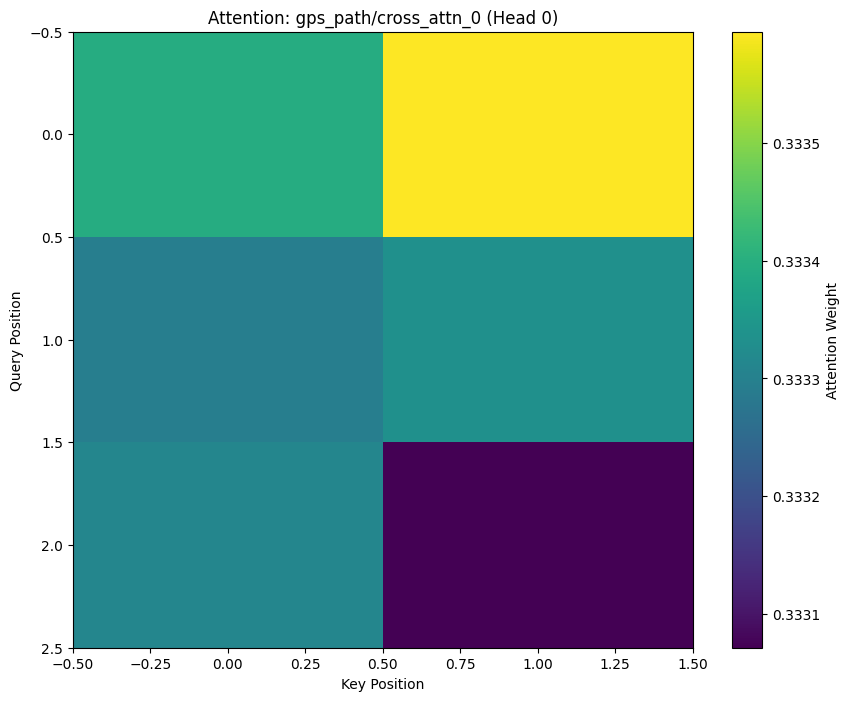

In [20]:
if 'results' in dir() and results:
    sample_attn = results[0]['attention_weights']
    first_key = list(sample_attn.keys())[0]
    plot_attention_heatmap(sample_attn, first_key)